In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('fixed_simulated_transaction_2024.csv')
df['Timestamp']=pd.to_datetime(df['Timestamp'],format='%Y/%m/%d %H:%M')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230596 entries, 0 to 230595
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Timestamp               230596 non-null  datetime64[ns]
 1   Account No              230596 non-null  float64       
 2   Balance                 230596 non-null  float64       
 3   Amount                  230596 non-null  float64       
 4   Third Party Account No  230596 non-null  float64       
 5   Third Party Name        230596 non-null  object        
 6   Classification Number   230596 non-null  float64       
 7   Classification Title    230596 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 14.1+ MB
None


## Recommendations by Classification

In [3]:
class2d=pd.get_dummies(df.iloc[:,[1,7]]).groupby('Account No').agg(sum).iloc[1:]

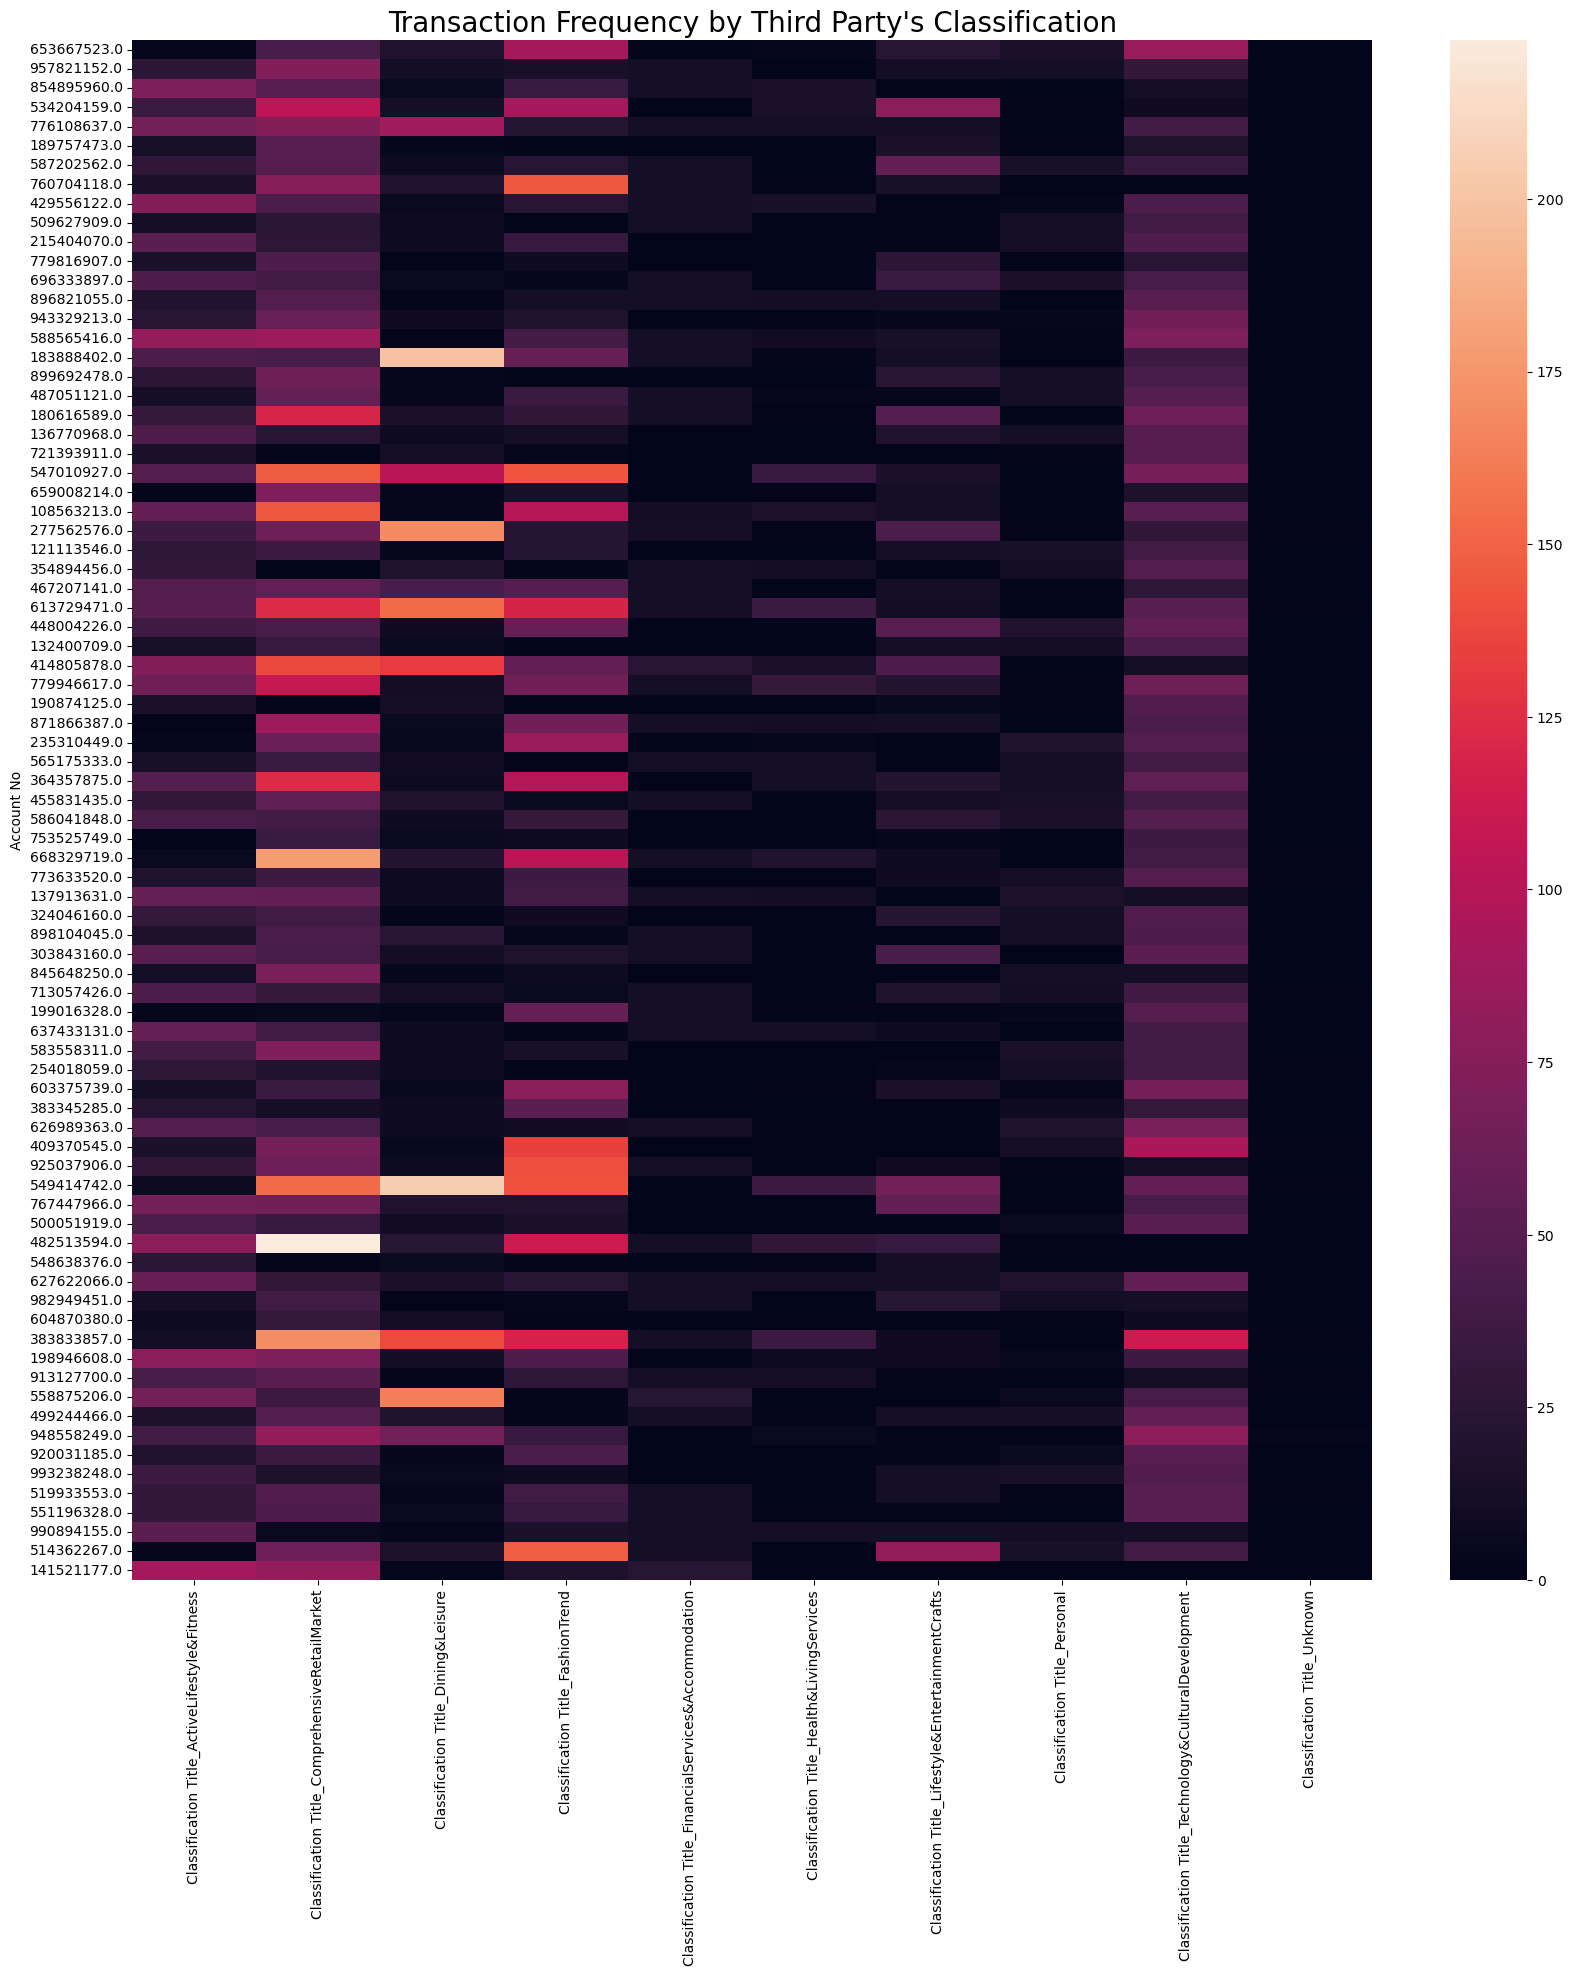

In [4]:
import seaborn as sns
plt.figure(figsize=(20,20))
sample=class2d.sample(80)
sns.heatmap(sample)
plt.title("Transaction Frequency by Third Party's Classification",fontsize=20)
plt.show()

* The heatmap above contains only 80 random samples.
* Each bright color block represents the user at the corresponding Y-axis coordinate tends to consume at the X-axis merchant.
* The brighter the color block, the stronger the tendency.
* Merchant classification is based on manual labor, check 'class2.xlsx' for details.

In [5]:
recommendation=pd.DataFrame(class2d.idxmax(axis=1))
recommendation.iloc[:,0]=recommendation.iloc[:,0].str.replace('Classification Title_','')
to_recommend=[]
for user in recommendation.index:
    a=set(df[df.iloc[:,7]==recommendation.loc[user,0]].iloc[:,5].to_list())
    b=set(df[df.iloc[:,1]==user].iloc[:,5].to_list())
    c=a.difference(b)
    to_recommend.append([user,c])
to_recommend=pd.DataFrame(to_recommend).rename(columns={0:'Account No',1:'Recommandation'}).set_index('Account No')

In [6]:
display(to_recommend.head(10))

,Recommandation
Account No,
101531259.0,"{Craftastic, Collector Cave, Wool, A Yarn Stor..."
104832000.0,"{Jollyes, Selfridges, Coop Local, Sainsbury, S..."
105375973.0,"{Mountain Warehouse, RugbyFields, Grand Union ..."
106601471.0,"{HMV, Green Park Academy, Foyles, Town High, C..."
108481285.0,"{Jollyes, Pets at Home, Pets Corner}"
108563213.0,"{Jollyes, Pets at Home, Pets Corner}"
108812033.0,"{Jollyes, Selfridges, Coop Local, Sainsbury, S..."
108931112.0,"{Frankie & Bennies, Costa Coffee, Kings Arms, ..."
111137699.0,"{Jollyes, Selfridges, Sainsbury, Sainsbury Loc..."


* Recommendations include all merchants that exist in the group corresponding to the current brightest color block of a single user and have not purchased from them.

## Recommendations by Unsupervised Machine Learning

In [7]:
# Set the number of user groups
num=10

In [8]:
income=df[df.Amount>0].iloc[:,[1,3]].groupby('Account No').agg('mean')
output=df[df.Amount<0].iloc[:,[1,3]].groupby('Account No').agg('mean')
balance=df.iloc[:,[1,2]].groupby('Account No').agg('mean')

In [9]:
from sklearn.cluster import KMeans

X=income.join(output,how='outer',lsuffix='_Income',rsuffix='_Output').fillna(0).join(balance)

kmeans=KMeans(n_clusters=num,random_state=0,n_init='auto').fit(X)
X['Label']=kmeans.labels_
label_dict=X.iloc[:,3].to_dict()
temp_df=X.reset_index()

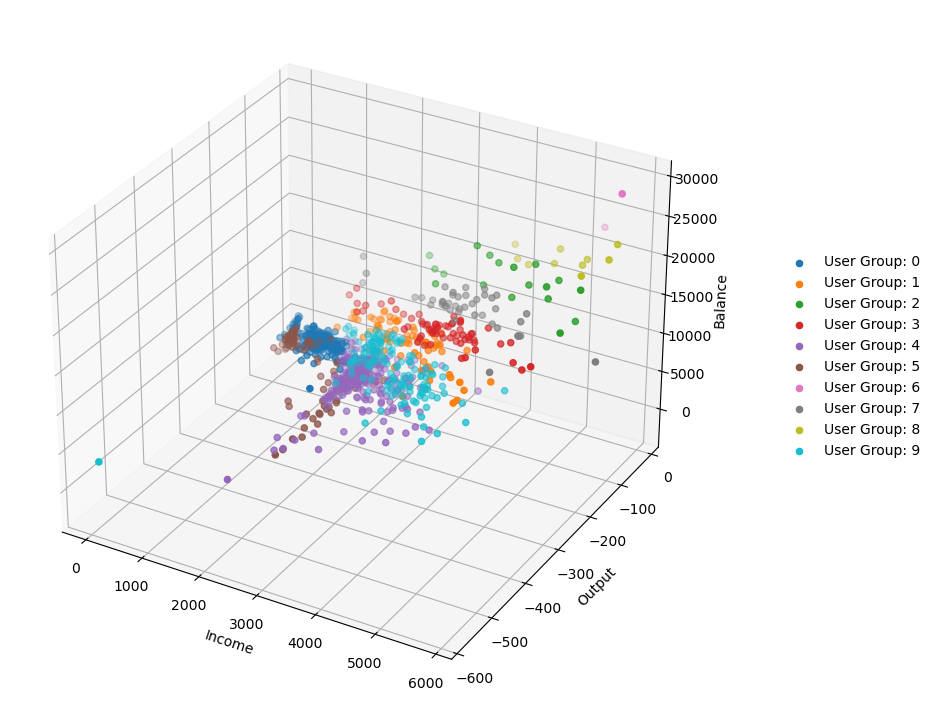

In [10]:
fig=plt.figure(figsize=(12,9))
ax=fig.add_subplot(projection='3d')

for name,idx in temp_df.groupby('Label').groups.items():
    x=temp_df.iloc[idx,1]
    y=temp_df.iloc[idx,2]
    z=temp_df.iloc[idx,3]
    ax.scatter(x,y,z,label='User Group: '+str(name))
    
ax.set_xlabel('Income')
ax.set_ylabel('Output')
ax.set_zlabel('Balance')
ax.legend(loc='center left',bbox_to_anchor=(1.1,.5),frameon=False)
plt.show()

In [11]:
temp_df=df.replace({'Account No':label_dict}).iloc[:,[1,5]]
class2d=pd.get_dummies(temp_df).groupby('Account No').agg(sum).T

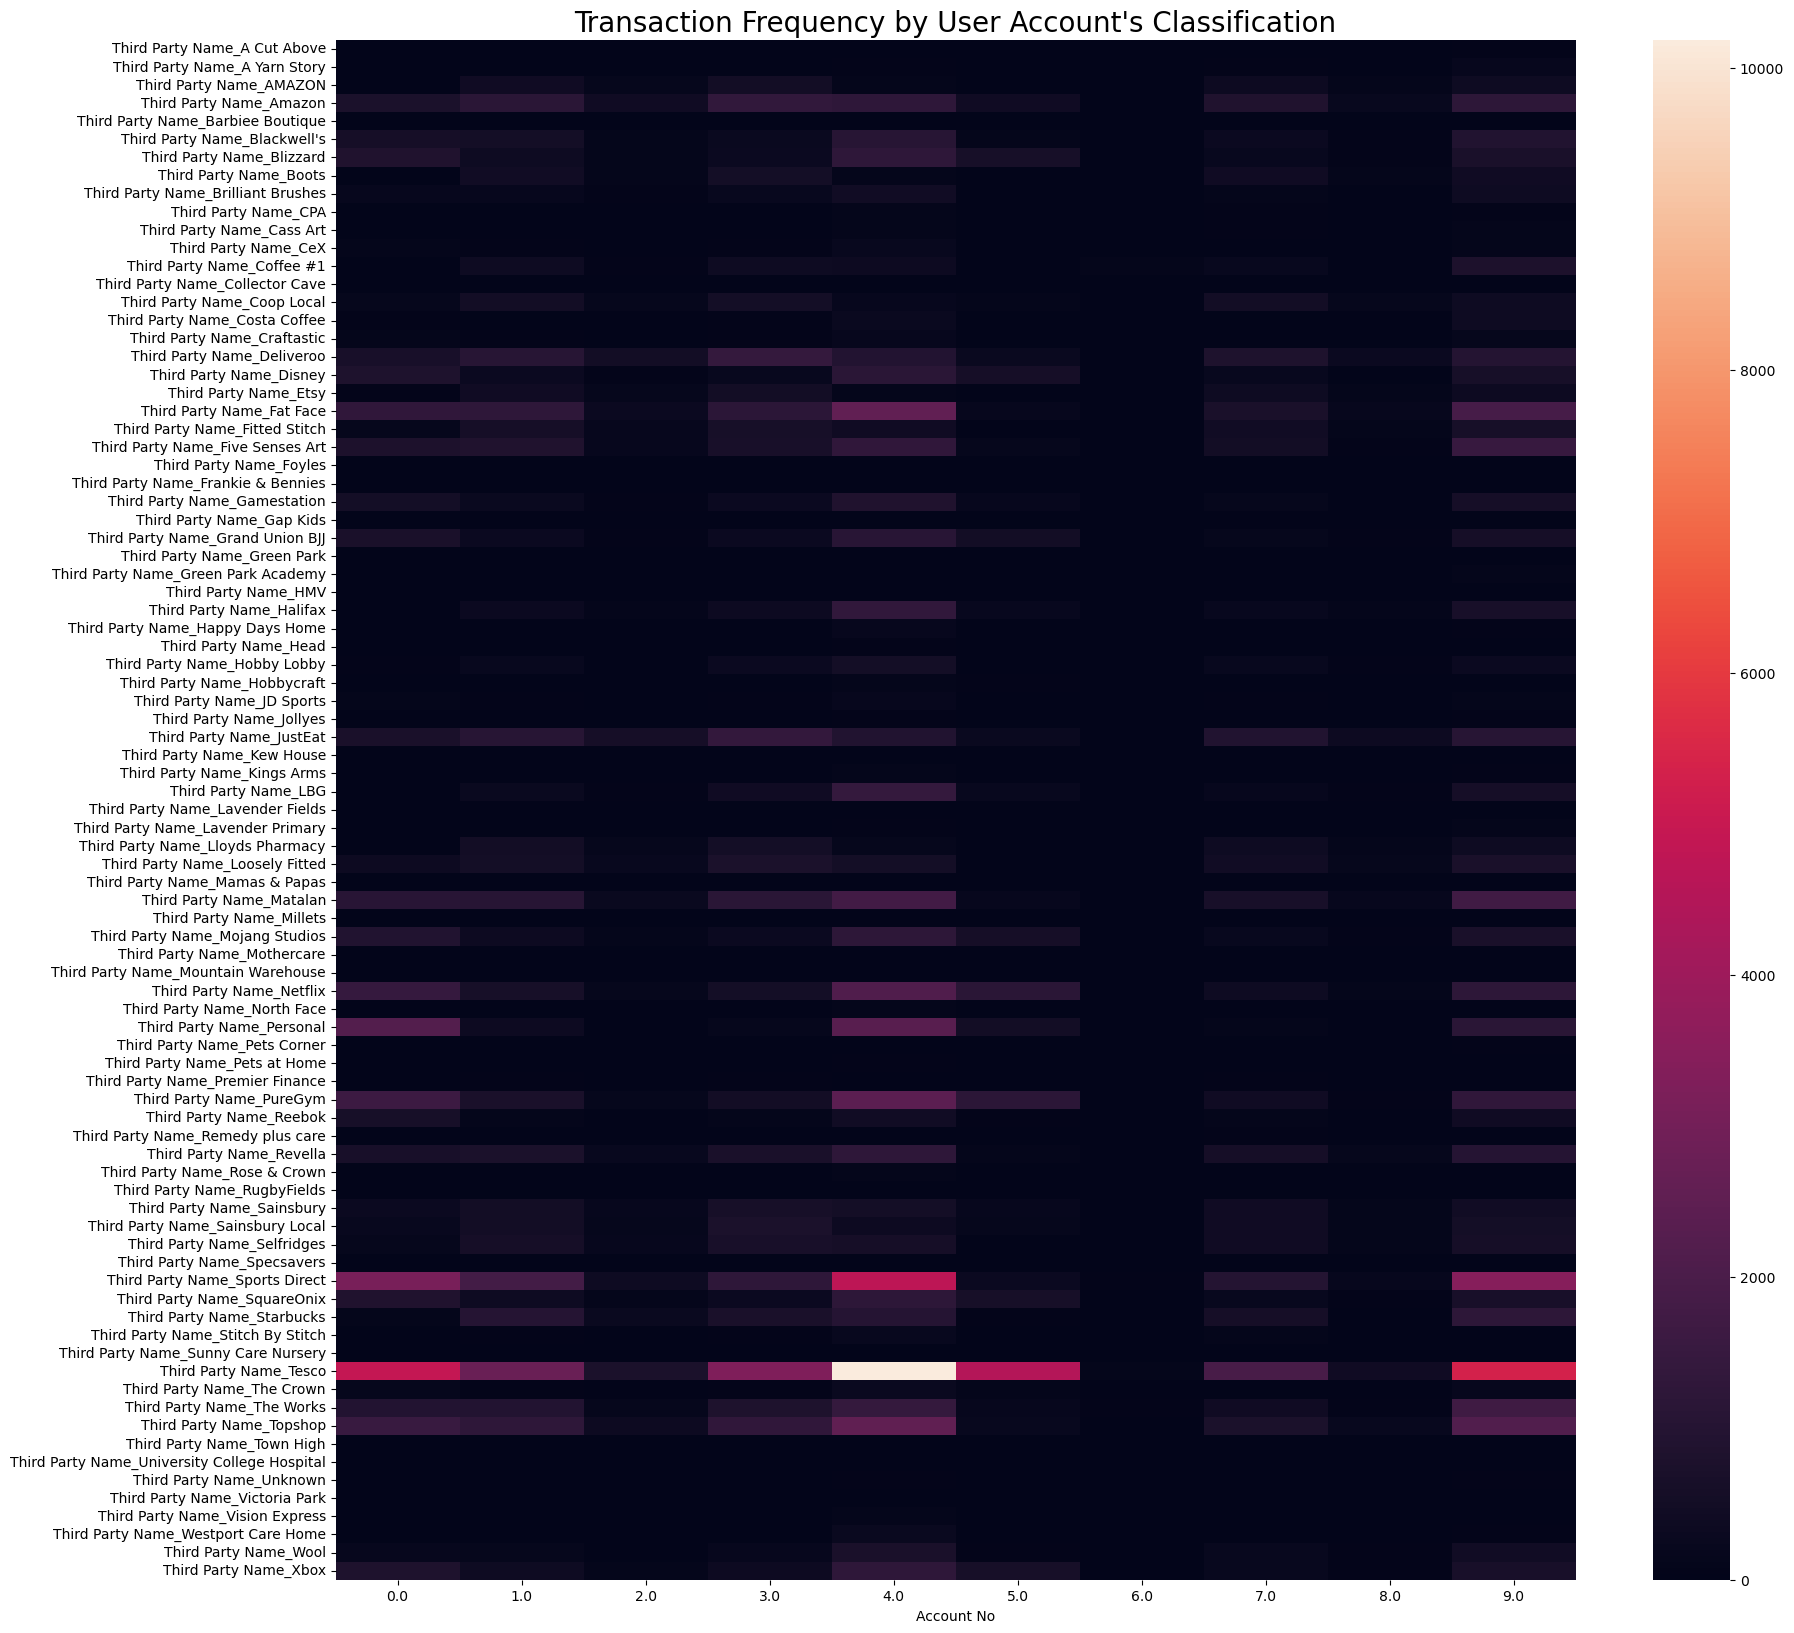

In [12]:
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(class2d)
plt.title("Transaction Frequency by User Account's Classification",fontsize=20)
plt.show()

* Each bright color block represents that the corresponding X-axis user group is a potential user of the Y-axis merchant.
* The brighter the color block, the higher the potential.
* User account classification is based on unsupervised machine learning (using the average of each user's balance, income, and output).

In [13]:
for n in range(num):
    print('\nAccount No in User Group '+str(n)+':')
    print(list(X[X.Label==n].index))


Account No in User Group 0:
[105375973.0, 108812033.0, 121113546.0, 127809299.0, 128030172.0, 132400709.0, 136770968.0, 143383029.0, 143606916.0, 147341222.0, 147508204.0, 152616936.0, 155317149.0, 155867488.0, 158766229.0, 160166876.0, 165098840.0, 168414279.0, 170233640.0, 190874125.0, 192202372.0, 197779140.0, 198630866.0, 202320275.0, 208381936.0, 211493028.0, 212560376.0, 213096759.0, 213930646.0, 214765415.0, 215404070.0, 216286013.0, 219399150.0, 223207876.0, 224215364.0, 248142083.0, 248625662.0, 248658670.0, 250957494.0, 252419513.0, 252964502.0, 254018059.0, 258201793.0, 261793952.0, 262767079.0, 280130290.0, 280200287.0, 280990953.0, 282046994.0, 283027736.0, 284161641.0, 293609137.0, 299652176.0, 299871610.0, 300095518.0, 310620484.0, 310740977.0, 311467864.0, 331048953.0, 333054026.0, 335698481.0, 344843570.0, 346874167.0, 347110339.0, 348460748.0, 355602925.0, 358836279.0, 364396689.0, 380911501.0, 382862215.0, 383345285.0, 384497904.0, 391559884.0, 401293808.0, 40686252